# Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

In [2]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


# Import Data

In [3]:
# Read saved list of data from object into a dataframe
raw_df = pd.read_pickle('DataSet/data.pkl')
print(len(raw_df))
raw_df.head()

200


,data,key,raw,timestamp
0,"[-2, -16, -15, -12, 3, 2, 8, 11, -26, -21, -6,...",delete,"[254, 255, 240, 255, 241, 255, 244, 255, 3, 0,...",2018-07-08 17:00:03.470304
1,"[7, 6, 2, 17, -1, 1, -17, -9, 2, -4, 9, -6, -2...",t,"[7, 0, 6, 0, 2, 0, 17, 0, 255, 255, 1, 0, 239,...",2018-07-08 17:00:10.196903
2,"[47, 49, 47, 40, 44, 51, 43, 35, 30, 38, 35, 4...",h,"[47, 0, 49, 0, 47, 0, 40, 0, 44, 0, 51, 0, 43,...",2018-07-08 17:00:10.824195
3,"[-13, -21, -16, -12, -18, -24, -18, -25, -22, ...",i,"[243, 255, 235, 255, 240, 255, 244, 255, 238, ...",2018-07-08 17:00:11.529678
4,"[81, 79, 65, 78, 86, 85, 74, 79, 82, 103, 116,...",s,"[81, 0, 79, 0, 65, 0, 78, 0, 86, 0, 85, 0, 74,...",2018-07-08 17:00:11.730209


In [4]:
data_width = len(raw_df['data'][0])

# Data Preprocessing

#### Filter out key counts less than threshold value

In [7]:
import collections
import matplotlib.pyplot as plt
key_count = collections.Counter(raw_df['key'])

In [12]:
width = 0.5 # Bar width
figsize = (15, 4)

def plot_key_hist(most_common):
    if len(most_common) > 30:
        most_common = most_common[:30]
        
    hist_labels, hist_values = zip(*most_common) # Show only a subset of all keys
    indexes = np.arange(len(hist_labels))
    plt.figure(figsize=figsize)
    plt.bar(indexes, hist_values, width)
    plt.xticks(indexes + width * 0.5, hist_labels, rotation='vertical')
    plt.show()

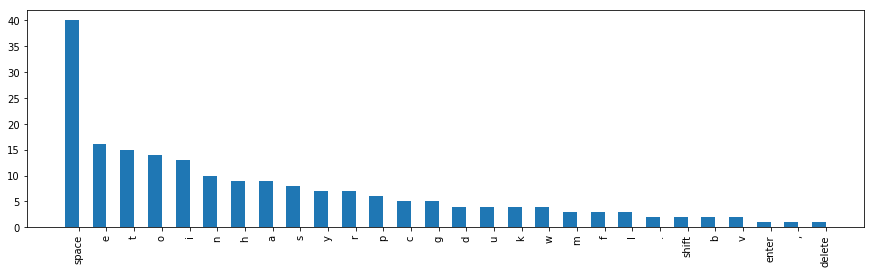

In [13]:
plot_key_hist(key_count.most_common())

#### Truncate DataFrame - Truncate extra key samples past threshold value

In [14]:
key_count.most_common

<bound method Counter.most_common of Counter({'space': 40, 'e': 16, 't': 15, 'o': 14, 'i': 13, 'n': 10, 'h': 9, 'a': 9, 's': 8, 'y': 7, 'r': 7, 'p': 6, 'c': 5, 'g': 5, 'd': 4, 'u': 4, 'k': 4, 'w': 4, 'm': 3, 'f': 3, 'l': 3, '.': 2, 'shift': 2, 'b': 2, 'v': 2, 'enter': 1, ',': 1, 'delete': 1})>

In [15]:
threshold = 16
min_thresh_keys = [key for key, count in zip(key_count.keys(), key_count.values()) if count > threshold]

In [17]:
min_thresh_df = raw_df[raw_df['key'].isin(min_thresh_keys)]

In [18]:
def trim_max_thresh(grouped_class):
    return grouped_class.sample(threshold)

In [40]:
df = min_thresh_df.groupby(['key']).apply(trim_max_thresh)

#### Plot truncated data

In [41]:
truncated_count = collections.Counter(df['key'])

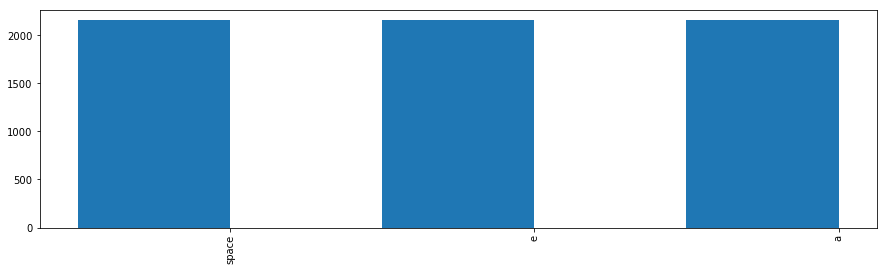

In [42]:
plot_key_hist(truncated_count.most_common())

#### Normalize Data

In [43]:
def pandas2npMat(df_col):
    np_array = np.float32([df_col[0]])
    for i, row in enumerate(df_col):
        if i == 0:
            pass
        else:
            np_array = np.concatenate((np_array, [row]), axis=0)
    return np_array

In [44]:
input_data = pandas2npMat(df['data']) # Convert pandas column to numpy matrix

In [45]:
def normalize(x):
    norm = (x - np.min(x)) / (np.max(x) - np.min(x))
    return norm

In [46]:
normalized_data = normalize(input_data)
normalized_data.shape

(6456, 4096)

#### One Hot Encode Classes

In [47]:
n_classes = len(set(df['key']))

In [48]:
labels_str = [str(key) for key in df['key']]
lb = preprocessing.LabelBinarizer() # Create encoder
lb.fit(list(set(labels_str)))
labels = lb.transform(labels_str)

In [49]:
lb.classes_

array(['a', 'e', 'space'], 
      dtype='<U5')

#### Split Training and Validation Data

Reshape to add 1 channel

In [50]:
normalized_data = normalized_data.reshape((normalized_data.shape[0], normalized_data.shape[1], 1))
# labels = labels.reshape((labels.shape[0], labels.shape[1], 1))
normalized_data.shape

(6456, 4096, 1)

In [51]:
from sklearn.model_selection import train_test_split
train_features, valid_features, train_labels, valid_labels = train_test_split(
    normalized_data, 
    labels, 
    test_size=0.1, 
    random_state=42)

# Define Network

### Input

In [52]:
def model_inputs(data_width, n_classes):
    """
    Create the model inputs
    :param data_width: The total number of samples in the recorded data point
    :param n_classes: Number of Classes
    :return: Tuple of (tensor of input audio data, key press labels, learning rate, keep_prob)
    """
    # TODO: Add audio channels to input
    
    with tf.name_scope("Inputs"):
        audio_inputs = tf.placeholder(tf.float32, [None, data_width, 1], name='inputs')
    with tf.name_scope("Targets"):
        key_labels = tf.placeholder(tf.float32, [None, n_classes], name='labels')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    keep_prob = tf.placeholder(tf.float32, name='keep_probability')

    return audio_inputs, key_labels, learning_rate, keep_prob

### Get Batches

In [53]:
def get_batches(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

### Network

In [54]:
def network(X, keep_prob, n_classes):
    """
    Create the network
    :param X: Tensor of input recording(s)
    :param keep_prob: Tensor for the keep probability
    :param n_classes: Number of Classes
    :return: Tuple of (tensor output of the classifier, tensor logits of the classifier)
    """    
    # Hyperparameters
    alpha = 0.2
    h_dim = 16
    
    #print("X: {}".format(X.shape))
     
    with tf.name_scope("Hidden_Layer1"):
        #h1 = tf.layers.dense(X, h_dim, activation=None)
        h1 = tf.layers.conv1d(X, h_dim, 5, 2, 'same', activation=None)
        #h1 = tf.layers.maxpool2d(h1, 5, 2, 'same')
        h1 = tf.layers.batch_normalization(h1)
        h1 = tf.nn.dropout(h1, keep_prob) # Regularization
        h1 = tf.maximum(h1*alpha, h1) # Leaky ReLu
        
    #print("h1: {}".format(h1.shape))

    with tf.name_scope("Hidden_Layer2"):
        #h2 = tf.layers.dense(h1, h_dim, activation=None)
        h2 = tf.layers.conv1d(h1, h_dim*2, 5, 2, 'same', activation=None)
        #h2 = tf.layers.maxpool2d(h2, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2)
        h2 = tf.nn.dropout(h2, keep_prob) # Regularization        
        h2 = tf.maximum(h2*alpha, h2) # Leaky ReLu
        
    #print("h2: {}".format(h2.shape))

    with tf.name_scope("Hidden_Layer3"):
        #h3 = tf.layers.dense(h2, h_dim, activation=None)
        h3 = tf.layers.conv1d(h2, h_dim*4, 3, 2, 'same', activation=None)
        #h3 = tf.layers.maxpool2d(h3, 3, 2, 'same')
        h3 = tf.layers.batch_normalization(h3)
        h3 = tf.nn.dropout(h3, keep_prob) # Regularization
        h3 = tf.maximum(h3*alpha, h3) # Leaky ReLu
        
    #print("h3: {}".format(h3.shape))
    
    
    
    with tf.name_scope("Output"):
        flat_dim = int(h3.get_shape()[1])*int(h3.get_shape()[2])
        flat = tf.reshape(h3, [-1, flat_dim])
        #print("flat: {}".format(flat.shape))
        logits = tf.layers.dense(flat, n_classes, activation=None, name='logits')
        #print("logits: {}".format(logits.shape))
        #out = tf.nn.softmax(logits, name='softmax_out')

    return logits

### Show Stats

In [55]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    with tf.name_scope("Validation_Stats"):
        validation_loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.0})
        validation_accuracy = session.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.0})
        print("Validation Accuracy: {}, Validation Loss: {}".format(validation_accuracy, validation_loss))

### Build Neural Network

In [56]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x, y, learn_rate, keep_prob = model_inputs(data_width, n_classes)

#Model
logits = network(x, keep_prob, n_classes)

with tf.name_scope("Cost"):
    # Cost and Optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y, name='loss'), name='cost')
    
with tf.name_scope("Train"):
    optimizer = tf.train.AdamOptimizer(learn_rate, name='optimizer').minimize(cost)

with tf.name_scope("Accuracy"):
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1), name='prediction')
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Write out the graph for TensorBoard

In [57]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    file_writer = tf.summary.FileWriter('./logs/2', sess.graph)

### Hyperparameters

In [58]:
epochs = 1000000
batch_size = 256
keep_probability = 0.9
learning_rate = 0.0001

# Train Neural Network

In [59]:
# Accuracy to beat
print("{:.3}%".format((1/n_classes)*100))

33.3%


In [36]:
save_model_path = './key_classification'

print('Training...')
with tf.Session() as sess:
    # Initialize the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        for batch_features, batch_labels in get_batches(train_features, train_labels, batch_size):
            sess.run(optimizer, feed_dict={x: batch_features, 
                                           y: batch_labels, 
                                           learn_rate: learning_rate, 
                                           keep_prob: keep_probability})
        if epoch % 50 == 0:
            print('Epoch {}: '.format(epoch), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)         
            
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch 0: Validation Accuracy: 0.24303796887397766, Validation Loss: 1.3855090141296387
Epoch 50: Validation Accuracy: 0.23797467350959778, Validation Loss: 1.3860313892364502
Epoch 100: Validation Accuracy: 0.23797467350959778, Validation Loss: 1.385907530784607
Epoch 150: Validation Accuracy: 0.23797467350959778, Validation Loss: 1.385672926902771
Epoch 200: Validation Accuracy: 0.24303796887397766, Validation Loss: 1.3838170766830444
Epoch 250: Validation Accuracy: 0.2329113781452179, Validation Loss: 1.3653600215911865
Epoch 300: Validation Accuracy: 0.25569623708724976, Validation Loss: 1.2504725456237793
Epoch 350: Validation Accuracy: 0.2797468304634094, Validation Loss: 1.1018407344818115
Epoch 400: Validation Accuracy: 0.2886075973510742, Validation Loss: 0.9681572914123535
Epoch 450: Validation Accuracy: 0.28734177350997925, Validation Loss: 0.8449752330780029
Epoch 500: Validation Accuracy: 0.2886075973510742, Validation Loss: 0.7319187521934509
Epoch 550: Validat

KeyboardInterrupt: 

### Test Model

In [ ]:
loaded_graph = tf.Graph()

with tf.Session(graph=loaded_graph) as sess: